In [29]:
import pandas as pd
import numpy as np
import seaborn as sns 

In [31]:
raw_file = pd.read_csv("data/202307-divvy-tripdata.csv")
base_dataframe = pd.DataFrame(raw_file)
base_dataframe.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
0,9340B064F0AEE130,electric_bike,2023-07-23 20:06,2023-07-23 20:22,Kedzie Ave & 110th St,20204,Public Rack - Racine Ave & 109th Pl,877,41.692406,-87.700905,41.694835,-87.653041,member,0:16:30,1
1,D1460EE3CE0D8AF8,classic_bike,2023-07-23 17:05,2023-07-23 17:18,Western Ave & Walton St,KA1504000103,Milwaukee Ave & Grand Ave,13033,41.898418,-87.686596,41.891578,-87.648384,member,0:13:30,1
2,DF41BE31B895A25E,classic_bike,2023-07-23 10:14,2023-07-23 10:24,Western Ave & Walton St,KA1504000103,Damen Ave & Pierce Ave,TA1305000041,41.898418,-87.686596,41.909396,-87.677692,member,0:09:36,1
3,9624A293749EF703,electric_bike,2023-07-21 8:27,2023-07-21 8:32,Racine Ave & Randolph St,13155,Clinton St & Madison St,TA1305000032,41.884112,-87.656943,41.882752,-87.641190,member,0:04:56,6
4,2F68A6A4CDB4C99A,classic_bike,2023-07-08 15:46,2023-07-08 15:58,Clark St & Leland Ave,TA1309000014,Montrose Harbor,TA1308000012,41.967088,-87.667291,41.963982,-87.638181,member,0:11:26,7


In [32]:
# check for percentage of blank cells in each column of the dataframe 
base_dataframe.isna().sum()/base_dataframe.shape[0]

ride_id               0.000000
rideable_type         0.000000
started_at            0.000000
ended_at              0.000000
start_station_name    0.160155
start_station_id      0.160155
end_station_name      0.169744
end_station_id        0.169744
start_lat             0.000000
start_lng             0.000000
end_lat               0.000000
end_lng               0.000000
member_casual         0.000000
ride_length           0.000000
day_of_week           0.000000
dtype: float64

In [33]:
# removing rides with blank data
cleaned_data = base_dataframe.dropna()
# number of rows and columns of cleaned data
cleaned_data.shape

(574023, 15)

In [34]:
# dropping rows with the same start and end times
def get_matching_rows_indexes(df, col1, col2):
    """
    Get a list of indexes of rows where the values in col1 and col2 are the same.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.

    Returns:
    list: A list of row indexes where the values in col1 and col2 are the same.
    """
    matching_indexes = df.index[df[col1] == df[col2]].tolist()
    return matching_indexes

rides_with_the_same_start_and_end_time = get_matching_rows_indexes(cleaned_data, "started_at", "ended_at")
cleaned_data = cleaned_data.drop(rides_with_the_same_start_and_end_time)


In [35]:
# getting distance of bike rides from longitude and lattitude co-ordinates
def deg2rad(deg):
    """
    Convert degrees to radians.

    Parameters:
    deg (float): Angle in degrees.

    Returns:
    float: Angle in radians.
    """
    return deg * (np.pi / 180)

def get_distance_from_lat_lon_in_m(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface specified by latitude and longitude using the Haversine formula.

    Parameters:
    lat1 (float): Latitude of the first point in degrees.
    lon1 (float): Longitude of the first point in degrees.
    lat2 (float): Latitude of the second point in degrees.
    lon2 (float): Longitude of the second point in degrees.

    Returns:
    float: Distance between the two points in meters.
    """

    R = 6371  # Radius of the Earth in km
    
    dLat = deg2rad(lat2 - lat1)
    dLon = deg2rad(lon2 - lon1)
    
    a = (np.sin(dLat / 2) * np.sin(dLat / 2) +
         np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) *
         np.sin(dLon / 2) * np.sin(dLon / 2))
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    d = R * c * 1000  # Distance in m
    return d

cleaned_data["ride_distance_meters"] = get_distance_from_lat_lon_in_m(
    cleaned_data["start_lat"],
    cleaned_data["start_lng"],
    cleaned_data["end_lat"], 
    cleaned_data["end_lng"]    
)

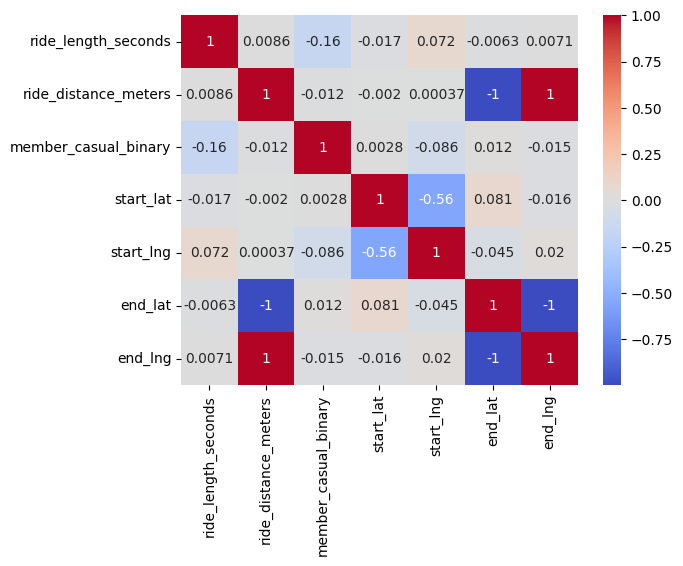

In [36]:
def get_seconds(time_str):
    """
    Get seconds from hh:mm:ss formatted time.
    
    Parameters: 
    time_str (string): time in hh:mm:ss format

    Returns:
    int: time in seconds
    """
    h, m, s = list(map(int, time_str.split(":")))
    return h * 3600 + m * 60 + s

# converting the hh:mm:ss format of time into seconds
cleaned_data["ride_length_seconds"] = cleaned_data["ride_length"].apply(get_seconds)

# converting member_casual to 1/0
cleaned_data["member_casual"] = cleaned_data["member_casual"].astype("category")
cleaned_data["member_casual_binary"] = cleaned_data["member_casual"].cat.codes

# correlation matrix
sns.heatmap(cleaned_data[["ride_length_seconds", "ride_distance_meters", "member_casual_binary", "start_lat", "start_lng", "end_lat", "end_lng"]].corr(), 
            annot=True, cmap="coolwarm")

# exporting the cleaned data to csv format
cleaned_data.to_csv("cleaned_data/clean-202307-divvy-tripdata.csv", index=False)